Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [368]:
%matplotlib inline

In [369]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [370]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [371]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [372]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [373]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

In [388]:

def lane(posx):
    ts = [90, 100, 150]
    rate = 8.0
    height = 10.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0])  + (posx - ts[0])/10.0, 1.0/10.0
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)) + (ts[1] - ts[0])/10.0, np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))

'''

def nominal(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))


def lane(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((ts[3] - posx)/(2 * rate)))
    
def nominal(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((posx - ts[3])/(2 * rate)))
'''

def barrier_u(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
                                                                      
def barrier_l(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    
def nominal(posx):
    return barrier_u(posx)[1] * 0.5 + barrier_l(posx)[1] * 0.5, (barrier_u(posx)[2] + barrier_l(posx)[2]) * 0.5

  

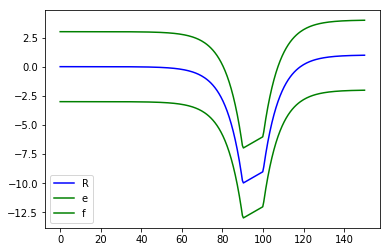

In [389]:
posx_path = np.linspace(0, 150, 300)
x_nominal = [[posx_path[i], nominal(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]
x_barrier_u = [[posx_path[i], barrier_u(posx_path[i])[1], 10, barrier_u(posx_path[i])[1]] for i in range(300)]
x_barrier_l = [[posx_path[i], barrier_l(posx_path[i])[1], 10, barrier_l(posx_path[i])[1]] for i in range(300)]
x_lane = [[posx_path[i], lane(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]

posx_ = np.asarray(x_nominal)[:, 0]
posy_ = np.asarray(x_lane)[:, 1]
posy_u = np.asarray(x_barrier_u)[:, 1]
posy_l = np.asarray(x_barrier_l)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_u, 'g')
_ = plt.plot(posx_, posy_l, 'g')
_ = plt.legend("Reference Path")


In [546]:
n = 2
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 100, checkpoint = 'checkpoints/mlp_H2.pt')

#agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
#agent.train(num_epoch = 1000)


In [518]:
def agent_run(agent, x0s):
    agent_traj = []
    for x0 in x0s:
        agent_traj.append([])
        for _ in range(0, N):
            i = abs(int(x0[0]/0.5))
            x_nn = []
            if i >= N - H - 1:
                break
            x_nominal_ = x_nominal[i: i + H]
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
            x1 = dynamics.f(x0, u[0], i)[0]        
            x0 = x1[:]
    return agent_traj

x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj = agent_run(agent, x0s)
        

print("Done")

Done


The red curve in the plot shows the trajectory of the regression model controller.

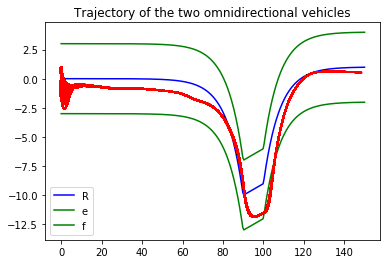

In [519]:
def draw_agent_traj(agent_trajs):
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.legend(["Vehicle", "Reference Path"])
    
    posx_ = np.asarray(x_nominal)[:, 0]
    posy_ = np.asarray(x_lane)[:, 1]
    posy_u = np.asarray(x_barrier_u)[:, 1]
    posy_l = np.asarray(x_barrier_l)[:, 1]
    _ = plt.plot(posx_, posy_, "b")
    _ = plt.plot(posx_, posy_u, 'g')
    _ = plt.plot(posx_, posy_l, 'g')
    _ = plt.legend("Reference Path")

    posx = []
    posy = []
    v = []
    theta = []
    for agent_traj in agent_trajs:
        posx.append([])
        posy.append([])
        v.append([])
        theta.append([])
        for j in agent_traj:
            posx[-1].append(j[0][0])
            posy[-1].append(j[0][1])
            v[-1].append(j[0][2])
            theta[-1].append(j[0][3])
            plt.plot(posx[-1], posy[-1], "r")

    plt.show()

draw_agent_traj(agent_traj)

In [568]:
N = len(x_nominal)
H = 2  # Number of time steps in trajectory.
n = 20
n_init = 0
#n_end = 250
n_end = N - H - 1

# Initial state.
x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
              x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
              x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)] for i in range(1)]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []

# Instantenous state cost.
Q = 0.0 * np.eye(dynamics.state_size)
Q[3, 3] = 0.0
Q[1, 1] = 0.0

R = np.eye(dynamics.action_size)
R[0, 0] = 0.0
R[1, 1] = 0.0


q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 10.0]
q2 = [150.0, 10.0]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

def MPSC(agent, x0s):
    train_traj = []
    nn_traj = []
    mpc_traj= []
    traj = []
    for num in range(len(x0s)):
        train_traj.append([])
        nn_traj.append([])
        mpc_traj.append([])
        traj.append([])
        x0 = x0s[num]
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            i = abs(int(x0[0]/0.5))
            if i > n_end:
                break
            x_nominal_ = x_nominal[i: i + H]
            x_nn = []
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            #print("NN outputs control")
            agent_traj[-1] = agent_traj[-1] + [[x0, u[0, :]]]
            x1 = dynamics.f(x0, u[0], i)[0]
            #print("Get next state")

            if i <= n_end - n - 1:
                n_ilqr =  n 
            elif n_end > i:
                n_ilqr = n_end - i
            else:
                break

            x0_ = x1[:]
            us_ = []
            xs_ = []
            for _ in range(n_ilqr):
                i_ = abs(int(x0_[0]/0.5))
                x_nn_ = []
                for j in [x0_] + x_nominal[i_ : i_ + H]:
                    for k in j:
                        x_nn_.append(k)
                while len(x_nn_) < 4 *(H + 1):
                    for k in x_nominal[-1]:
                        x_nn_.append(k)
                u_ = agent.run([x_nn_])
                xs_.append(x0_[:])
                us_.append(u_[0])
                x1_ = dynamics.f(x0_, u_[0], i_)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[0].T) - b[0,0]\
                           <= 0)).all() == True and \
                (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[1].T) - b[1,0]\
                          <= 0)).all() == True:
                traj[-1].append([x0, u[0, :]])
                nn_traj[-1].append(traj[-1][-1])
                #train_traj[-1].append([x_nn, u[0, :]])
                print("Utilize NN output {}".format(u))
            else: 
                x_nominal_ilqr = x_nominal[i + 1: i + 1 + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))


                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
                try:
                    xs, us = ilqr_.fit(x1, us_init, on_iteration=on_iteration)
                except TypeError as e:
                    print(e)
                    return traj, nn_traj, mpc_traj, train_traj
                us = np.exp(-np.logaddexp(0, -us))
                #print("MPC verifying")


                if (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    traj[-1].append([x0, u[0, :]])
                    nn_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, u[0, :]])
                    print("Utilize NN output {}".format(u))
                else:
                    max_itr = 50
                    while (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == False or \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == False :

                        if max_itr == 0:
                            return  traj, nn_traj, mpc_traj, train_traj
                        max_itr -= 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, n_iterations = (51 - max_itr) * 100, on_iteration=on_iteration)
                        us_init = us[:] + 2 * np.random.random((n - 1, dynamics.action_size)) - 1.0
                        us_init = np.zeros((n - 1, dynamics.action_size))

                        us = np.exp(-np.logaddexp(0, -us))
                    traj[-1].append([x0, us[0]])
                    mpc_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, us[0]])
                    x1 = dynamics.f(x0, us[0], i)[0]
                    print("Utilize MPC output {}".format(us[0]))
                    
            x0 = x1[:]
            
        return  traj, nn_traj, mpc_traj, train_traj
    
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)


>>>>>Step 0 at [-0.27599286968619174, 0.4260317524786428, 10.29171280988729, -1.0956487471590561]
Utilize NN output [[0.08517524 0.64001167]]
>>>>>Step 1 at [-0.04053695 -0.03164522 10.2959613  -0.80495546]
Utilize NN output [[0.06530612 0.4971782 ]]
>>>>>Step 2 at [ 0.3163484  -0.40277031 10.29922197 -0.56820237]
Utilize NN output [[0.04370271 0.38211846]]
>>>>>Step 3 at [ 0.75043951 -0.67990939 10.30140572 -0.38047546]
Utilize NN output [[0.0500737 0.3128852]]
>>>>>Step 4 at [ 1.22873425 -0.87121013 10.30390731 -0.22437847]
Utilize NN output [[0.05414611 0.24993981]]
>>>>>Step 5 at [ 1.73108092 -0.98585638 10.30661198 -0.09822666]
Utilize NN output [[0.05557343 0.18704903]]
>>>>>Step 6 at [ 2.24399650e+00 -1.03640103e+00  1.03093878e+01 -2.94322160e-03]
Utilize NN output [[0.0555039  0.12948583]]
>>>>>Step 7 at [ 2.75953297 -1.03791837 10.31216014  0.06343221]
Utilize NN output [[0.05416577 0.07892043]]
>>>>>Step 8 at [ 3.27417151 -1.00522985 10.31486578  0.10403995]
Utilize NN outpu

Utilize NN output [[ 0.08041875 -0.00013513]]
>>>>>Step 88 at [ 4.49646530e+01 -9.28254197e-01  1.05915849e+01 -1.40276479e-02]
Utilize NN output [[ 0.07769755 -0.00022317]]
>>>>>Step 89 at [ 4.54942771e+01 -9.35684064e-01  1.05954620e+01 -1.41458326e-02]
Utilize NN output [[ 0.075071   -0.00030816]]
>>>>>Step 90 at [ 4.60240908e+01 -9.43179221e-01  1.05992085e+01 -1.43090893e-02]
Utilize NN output [[ 0.14987533 -0.00385695]]
>>>>>Step 91 at [ 4.65541829e+01 -9.50764874e-01  1.06066466e+01 -1.63531076e-02]
Utilize NN output [[ 0.14324506 -0.00266072]]
>>>>>Step 92 at [ 4.70846222e+01 -9.59439977e-01  1.06137603e+01 -1.77641715e-02]
Utilize NN output [[ 0.13697702 -0.00177315]]
>>>>>Step 93 at [ 4.76153966e+01 -9.68869737e-01  1.06205666e+01 -1.87051623e-02]
Utilize NN output [[ 0.13103609 -0.00113953]]
>>>>>Step 94 at [ 4.81464949e+01 -9.78805175e-01  1.06270812e+01 -1.93102840e-02]
Utilize NN output [[ 0.12539814 -0.00071327]]
>>>>>Step 95 at [ 4.86779058e+01 -9.89068146e-01  1.063331

Utilize NN output [[ 0.02454566 -0.02750124]]
>>>>>Step 156 at [81.32023235 -3.68637775 10.84170594 -0.29316679]
Utilize NN output [[ 0.02299765 -0.03001465]]
>>>>>Step 157 at [81.83921629 -3.84304076 10.84285562 -0.30943241]
Utilize NN output [[ 0.02153477 -0.03077058]]
>>>>>Step 158 at [82.35563648 -4.00814122 10.84393219 -0.32610919]
Utilize NN output [[ 0.02023109 -0.03250655]]
>>>>>Step 159 at [82.8692811  -4.18184728 10.84494361 -0.34372793]
Utilize NN output [[ 0.01917266 -0.03292286]]
>>>>>Step 160 at [83.37983204 -4.36459227 10.84590213 -0.36157381]
Utilize NN output [[ 0.0183014  -0.03349926]]
>>>>>Step 161 at [83.88708441 -4.55643548 10.84681709 -0.3797335 ]
Utilize NN output [[ 0.01756582 -0.0365478 ]]
>>>>>Step 162 at [84.39081117 -4.75747471 10.84769529 -0.39954605]
Utilize NN output [[ 0.0170043  -0.04022457]]
>>>>>Step 163 at [84.89049603 -4.96847075 10.84854543 -0.42135148]
Utilize NN output [[ 0.01688341 -0.0505167 ]]
>>>>>Step 164 at [85.38550025 -5.19032894 10.84938

Utilize NN output [[ 0.02264307 -0.45070425]]
>>>>>Step 199 at [100.93263393  -9.61748015  10.99923305   0.57342982]
iteration 0 accepted [-2793.33356868] [97.69105673 -8.08332941 10.64979395  2.39541968] [14.015051 -4.232278]
Utilize NN output [[ 0.0112185  -0.38779613]]
>>>>>Step 200 at [101.39463834  -9.31910931  10.99979395   0.37024168]
iteration 0 accepted [36076.3412458] [99.73960216 -7.24051145 10.55038883  1.66009537] [15.456252  -2.9526906]
Utilize NN output [[ 0.01189811 -0.18338166]]
>>>>>Step 201 at [101.90737456  -9.12009525  11.00038883   0.27049923]
iteration 0 failed 32643915.03495626 [110.74437455  -2.84740762  11.01268712   0.52677592] [ 0.01059463 -0.07566717]
Utilize NN output [[ 0.01217382 -0.0135359 ]]
>>>>>Step 202 at [102.43740865  -8.97311908  11.00099749   0.26305468]
iteration 0 failed 32642431.177712623 [111.22037254  -2.57056992  11.01323224   0.48717252] [ 0.01090283 -0.07204763]
iteration 0 failed 15856466.135229766 [110.99846253  -3.14466213  11.0126293

Utilize NN output [[0.00336757 0.00372077]]
>>>>>Step 274 at [1.39465998e+02 5.92337860e-01 1.10300462e+01 3.91687199e-04]
Utilize NN output [[0.00306231 0.00335647]]
>>>>>Step 275 at [1.40017504e+02 5.92553878e-01 1.10301993e+01 2.24277929e-03]
Utilize NN output [[ 0.00617166 -0.01324759]]
>>>>>Step 276 at [ 1.40569020e+02  5.93790809e-01  1.10305079e+01 -5.06296945e-03]
Utilize NN output [[ 0.00558546 -0.00803576]]
>>>>>Step 277 at [ 1.41120546e+02  5.90998430e-01  1.10307871e+01 -9.49480099e-03]
Utilize NN output [[ 0.00506215 -0.00385131]]
>>>>>Step 278 at [ 1.41672067e+02  5.85761692e-01  1.10310402e+01 -1.16189410e-02]
Utilize NN output [[ 0.00459317 -0.00067363]]
>>>>>Step 279 at [ 1.42223587e+02  5.79353319e-01  1.10312699e+01 -1.19904825e-02]
Utilize NN output [[0.00417157 0.00159164]]
>>>>>Step 280 at [ 1.42775116e+02  5.72739903e-01  1.10314785e+01 -1.11125906e-02]
Utilize NN output [[0.00379078 0.00306053]]
>>>>>Step 281 at [ 1.43326661e+02  5.66610561e-01  1.10316680e+01 -

291


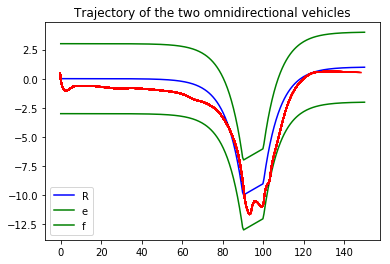

In [569]:
print(len(traj[0]))

draw_agent_traj(traj)
#pickle.dump((traj, nn_traj, mpc_traj, train_traj), open('safe_path_bk1.p', 'wb'))

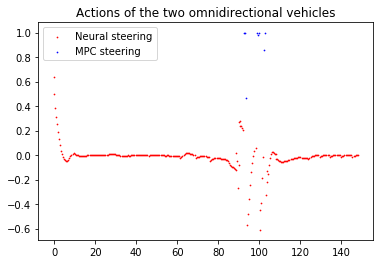

In [570]:
def draw_str(nn_traj, mpc_traj):
    str_nn = []
    posx_nn = []
    str_mpc = []
    posx_mpc = []
    for i in nn_traj[-1]:
        posx_nn.append(i[0][0])
        str_nn.append(i[1][1])
    for j in mpc_traj[-1]:
        posx_mpc.append(j[0][0])
        str_mpc.append(j[1][1])  

    _ = plt.title("Actions of the two omnidirectional vehicles")
    _ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
    _ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
    _ = plt.legend(["Neural steering", "MPC steering"])

draw_str(nn_traj, mpc_traj)

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

100
2700
[Epoch 1] avg_loss: 0.202
[Epoch 51] avg_loss: 0.165
Finished Training


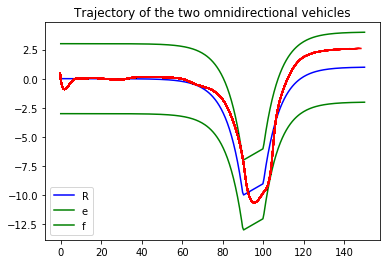

>>>>>Step 0 at [-0.27599286968619174, 0.4260317524786428, 10.29171280988729, -1.0956487471590561]
Utilize NN output [[0.0667901 0.6382819]]
>>>>>Step 1 at [-0.0405474  -0.03162491 10.29504736 -0.80556212]
Utilize NN output [[0.05410765 0.5418198 ]]
>>>>>Step 2 at [ 0.31607142 -0.40292341 10.2977501  -0.55108695]
Utilize NN output [[0.03996558 0.46034378]]
>>>>>Step 3 at [ 0.7547754  -0.67255164 10.29974732 -0.32949772]
Utilize NN output [[0.04780658 0.38578227]]
>>>>>Step 4 at [ 1.24211551 -0.83920429 10.30213583 -0.14012735]
Utilize NN output [[0.05240092 0.3038349 ]]
>>>>>Step 5 at [ 1.75223814 -0.91115799 10.30475348  0.01173547]
Utilize NN output [[0.05460326 0.22211243]]
>>>>>Step 6 at [ 2.26750852 -0.90511077 10.30748093  0.12433064]
Utilize NN output [[0.05479622 0.1442037 ]]
>>>>>Step 7 at [ 2.77897224 -0.84119046 10.310218    0.19813858]
Utilize NN output [[0.05378867 0.07630915]]
>>>>>Step 8 at [ 3.28446286 -0.73970166 10.31290485  0.2374006 ]
Utilize NN output [[0.05207295 0

Utilize NN output [[ 0.10172714 -0.00565202]]
>>>>>Step 68 at [3.43649552e+01 5.53207626e-02 1.05011360e+01 3.02469331e-02]
Utilize NN output [[ 0.09886002 -0.00595376]]
>>>>>Step 69 at [3.48898950e+01 7.12034241e-02 1.05060630e+01 2.71209101e-02]
Utilize NN output [[ 0.09629585 -0.00623824]]
>>>>>Step 70 at [3.54151249e+01 8.54516313e-02 1.05108629e+01 2.38439866e-02]
Utilize NN output [[ 0.09381074 -0.00616236]]
>>>>>Step 71 at [3.59406355e+01 9.79842752e-02 1.05155398e+01 2.06054394e-02]
Utilize NN output [[ 0.091388   -0.00580347]]
>>>>>Step 72 at [3.64664148e+01 1.08819722e-01 1.05200965e+01 1.75541439e-02]
Utilize NN output [[ 0.08903295 -0.00526776]]
>>>>>Step 73 at [3.69924496e+01 1.18054760e-01 1.05245364e+01 1.47833037e-02]
Utilize NN output [[ 0.08674992 -0.00464183]]
>>>>>Step 74 at [3.75187270e+01 1.25835447e-01 1.05288630e+01 1.23406634e-02]
Utilize NN output [[ 0.17276464 -0.01026014]]
>>>>>Step 75 at [3.80453439e+01 1.32334578e-01 1.05374163e+01 6.93947267e-03]
Utilize 

Utilize NN output [[ 0.06482132 -0.00731137]]
>>>>>Step 140 at [ 7.29822115e+01 -8.24896156e-01  1.09512126e+01 -6.43346555e-02]
Utilize NN output [[ 0.0594621  -0.00897953]]
>>>>>Step 141 at [ 7.35287135e+01 -8.60103758e-01  1.09541822e+01 -6.92513625e-02]
Utilize NN output [[ 0.11334224 -0.03902036]]
>>>>>Step 142 at [74.07525048 -0.89801281 10.95982517 -0.09061233]
Utilize NN output [[ 0.1027289  -0.03221354]]
>>>>>Step 143 at [74.62112105 -0.94761124 10.96494362 -0.10825897]
Utilize NN output [[ 0.09341336 -0.02653897]]
>>>>>Step 144 at [75.16627439 -1.00686062 10.96960075 -0.12280547]
Utilize NN output [[ 0.08519898 -0.02211655]]
>>>>>Step 145 at [75.7107292  -1.07406081 10.97385043 -0.13493398]
Utilize NN output [[ 0.07791236 -0.01895896]]
>>>>>Step 146 at [76.25453053 -1.14788668 10.97773818 -0.14533537]
Utilize NN output [[ 0.07140397 -0.01699568]]
>>>>>Step 147 at [76.7977189  -1.22739173 10.98130232 -0.15466317]
Utilize NN output [[ 0.06555486 -0.01611288]]
>>>>>Step 148 at [

Utilize NN output [[ 0.0240636  -0.02533202]]
>>>>>Step 235 at [118.39674509   1.66008997  11.23613503   0.14068409]
Utilize NN output [[ 0.02172032 -0.02237338]]
>>>>>Step 236 at [118.95302824   1.73887059  11.23722087   0.12811668]
Utilize NN output [[ 0.01959262 -0.01942299]]
>>>>>Step 237 at [1.19510309e+02 1.81066073e+00 1.12382004e+01 1.17205030e-01]
Utilize NN output [[ 0.03894377 -0.05120038]]
>>>>>Step 238 at [1.20068412e+02 1.87637442e+00 1.12401466e+01 8.84601377e-02]
Utilize NN output [[ 0.03424346 -0.01463807]]
>>>>>Step 239 at [1.20628264e+02 1.92602863e+00 1.12418581e+01 8.02340221e-02]
Utilize NN output [[ 0.03076496 -0.00953369]]
>>>>>Step 240 at [1.21188587e+02 1.97108231e+00 1.12433958e+01 7.48753648e-02]
Utilize NN output [[ 0.02768558 -0.00644959]]
>>>>>Step 241 at [1.21749217e+02 2.01313825e+00 1.12447798e+01 7.12496517e-02]
Utilize NN output [[ 0.02494159 -0.00473529]]
>>>>>Step 242 at [1.22310060e+02 2.05316592e+00 1.12460266e+01 6.85873053e-02]
Utilize NN outpu

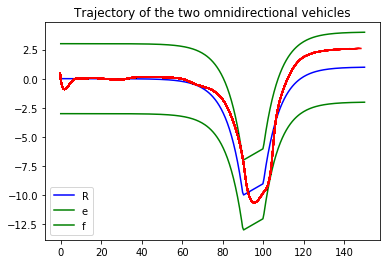

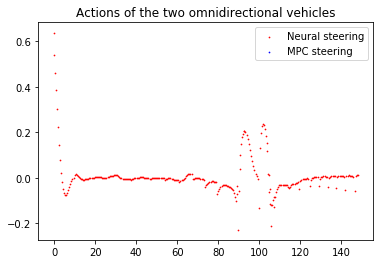

In [571]:
def train_temp(agent, x0s, train_traj = None, paths = None):

    
    #agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 1, checkpoint = 'checkpoints/mlp_H2_995.pt')
    
    X = []
    Y = []
    
    if train_traj is not None and train_traj is not []:
        print(len(train_traj))
        for i_traj in range(len(train_traj)):
            for i_xy in range(len(train_traj[i_traj])):
                X.append([x for x in train_traj[i_traj][i_xy][0]])
                Y.append([y for y in train_traj[i_traj][i_xy][1]])
    if train_traj is not None or paths is not None:
        agent.data_process(X = X, Y = Y, paths = paths)
        
    n = int(np.asarray(X[0]).shape[0]/dynamics.state_size) - 1
    agent.train(num_epoch = 100)
    #for i in range(len(X)):
    #    print(agent_.run([X[i]]), Y[i])

    agent_temp_traj = agent_run(agent, x0s)    
    draw_agent_traj(agent_temp_traj)
    
    # Random initial action path.
    us_init = np.zeros((n - 1, dynamics.action_size))

    J_hist = []
    q1 = [100.0, 10.0]
    q2 = [100.0, 10.0]

    traj_, nn_traj_, mpc_traj_, train_traj_ = MPSC(agent, x0s)
    draw_agent_traj(traj_)
    draw_str(nn_traj_, mpc_traj_)
    return train_traj_

H = 2 
agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_H2.pt')
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']

train_traj_aggr = 100 * train_traj

train_traj_ = train_temp(agent_, x0s[:itr_train], train_traj_aggr, paths = None) 

342
2700
[Epoch 1] avg_loss: 0.168
[Epoch 51] avg_loss: 0.164
Finished Training


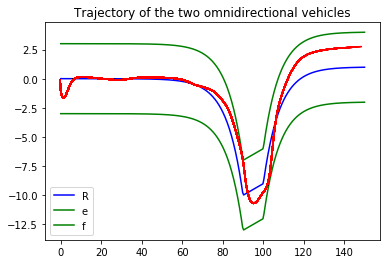

>>>>>Step 0 at [-0.2999364899086613, -0.17488259691580477, 9.74754677570714, -1.3859109565659438]
Utilize NN output [[0.37376744 0.9216605 ]]
>>>>>Step 1 at [-0.21025793 -0.65439272  9.76541091 -1.03174262]
Utilize NN output [[0.3275028 0.8387737]]
>>>>>Step 2 at [ 0.04058605 -1.07376325  9.78122466 -0.69719966]
Utilize NN output [[0.24948436 0.71184427]]
>>>>>Step 3 at [ 0.41575577 -1.38797261  9.79344636 -0.39797634]
Utilize NN output [[0.17156287 0.5992794 ]]
>>>>>Step 4 at [ 0.86735458 -1.5778292   9.80194132 -0.13524921]
Utilize NN output [[0.18747018 0.476635  ]]
>>>>>Step 5 at [ 1.35320548 -1.64394378  9.81120654  0.08213072]
Utilize NN output [[0.2018266  0.36800015]]
>>>>>Step 6 at [ 1.84236029 -1.60367856  9.82116305  0.2549263 ]
Utilize NN output [[0.21444888 0.23841892]]
>>>>>Step 7 at [ 2.31780386 -1.47977984  9.83172409  0.36983479]
Utilize NN output [[0.22228087 0.11956477]]
>>>>>Step 8 at [ 2.77640736 -1.3019916   9.84265864  0.42833269]
Utilize NN output [[0.2268792  0

Utilize NN output [[ 0.19460107 -0.00137632]]
>>>>>Step 111 at [ 5.51681192e+01  4.59532560e-02  1.06571536e+01 -1.84169231e-02]
Utilize NN output [[ 0.186001  -0.0016207]]
>>>>>Step 112 at [ 5.57011163e+01  3.61359788e-02  1.06663479e+01 -1.92805253e-02]
Utilize NN output [[ 0.17796727 -0.0022374 ]]
>>>>>Step 113 at [ 5.62345547e+01  2.58497322e-02  1.06751535e+01 -2.04737667e-02]
Utilize NN output [[ 0.17027156 -0.00270476]]
>>>>>Step 114 at [ 5.67684112e+01  1.49181499e-02  1.06835857e+01 -2.19174471e-02]
Utilize NN output [[ 0.16007823 -0.00483771]]
>>>>>Step 115 at [ 5.73026606e+01  3.20689273e-03  1.06915220e+01 -2.45016294e-02]
Utilize NN output [[ 0.14959046 -0.0067947 ]]
>>>>>Step 116 at [ 5.78372618e+01 -9.89432944e-03  1.06989462e+01 -2.81338567e-02]
Utilize NN output [[ 0.13978006 -0.00794355]]
>>>>>Step 117 at [ 5.83721709e+01 -2.49473584e-02  1.07058900e+01 -3.23831456e-02]
Utilize NN output [[ 0.13063794 -0.00848603]]
>>>>>Step 118 at [ 5.89073471e+01 -4.22841059e-02  1.

Utilize NN output [[ 0.05342444 -0.11160727]]
>>>>>Step 215 at [106.08679902  -3.69219033  11.14469139   0.821735  ]
Utilize NN output [[ 0.06329941 -0.10068095]]
>>>>>Step 216 at [106.46630263  -3.28405378  11.14785214   0.76582089]
Utilize NN output [[ 0.03376213 -0.139505  ]]
>>>>>Step 217 at [106.86810922  -2.89767959  11.14953961   0.68856238]
Utilize NN output [[ 0.03715768 -0.11224481]]
>>>>>Step 218 at [107.29860667  -2.54341374  11.15139664   0.62624995]
Utilize NN output [[ 0.03943266 -0.09002934]]
>>>>>Step 219 at [107.75040703  -2.21658734  11.15336725   0.57618749]
Utilize NN output [[ 0.04076866 -0.07231574]]
>>>>>Step 220 at [108.21808026  -1.91272461  11.15540456   0.53592945]
Utilize NN output [[ 0.04135944 -0.05857819]]
>>>>>Step 221 at [108.6976924   -1.62787822  11.15747135   0.5032936 ]
Utilize NN output [[ 0.04137708 -0.0482721 ]]
>>>>>Step 222 at [109.18643424  -1.35878342  11.15953902   0.47638477]
Utilize NN output [[ 0.04095789 -0.04084444]]
>>>>>Step 223 at [

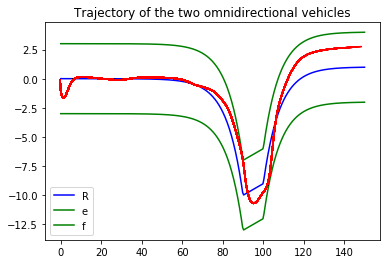

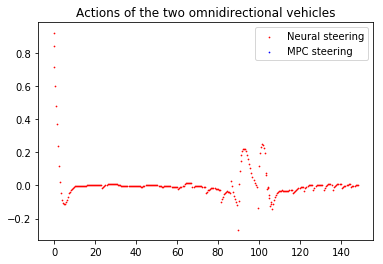

In [579]:

#raise TypeError
itr_train = 2
batch_size = 3
'''

'''

while itr_train < batch_size:
    # Initial state.
    agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_temp_H2.pt')
    train_traj_aggr = train_traj_aggr + int((batch_size - itr_train) * 120 + 1) * train_traj_[:]
    train_traj_ = train_temp(agent_, x0s[:itr_train], train_traj_aggr, paths = None) 
    itr_train += 1
    
    x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
                  x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)]]

Done


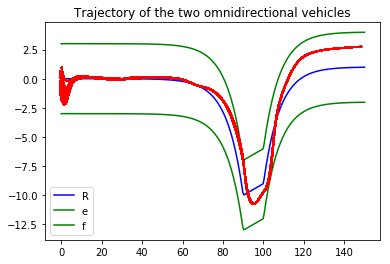

In [580]:
#x0s = []
batch_size = 20
for i_batch in range(batch_size):
    
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj_ = agent_run(agent_, x0s)
        

print("Done")
draw_agent_traj(agent_traj_)

<h2>MPSC Guided Policy Search</h2>

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=\pi(x_k; \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& \pi(x_k; \theta)\\
u_k + \delta u_k &=& \pi(x_k + \delta x_k; \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x \pi(x_k; \theta) \delta x_k + \nabla_\theta \pi(x_k; \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

Previously, we used L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$, to estimate the loss $L(\delta\theta)$. The optimization problem is as follows.

\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

It is a typical Quadratic Programming problem especially if the constrains are all convex. But it would be extremely computationally expensive for traditional QP solver because the size of $\nabla_\theta \pi(x; \theta)$ can be immensively large. 

Considering the difficulty, we can alternate the problem in the following way.

Firstly, given the current model parameter $\theta_i$, the linearization of the perturbation on the learning model can be rearranged in the following way.

$$\delta \theta_i^T \nabla_\theta \pi(x_k; \theta_i) \approx \delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)$$

Let the optimal control at state $x_k$ be $u^*_k$, which can be presumably obtained with the initial model parametere $\theta_0$, i.e. $u^*_k= \pi(x_k; \theta_0)$. The loss of the model based on this specific data point can be evaluated by using square error  
$$J_{(x_k, u^*_k)}(\theta_i) = ||\pi(x_k; \theta_i) - u^*_k||^2_2$$ 
or log likelihood with fixed covariance $\Sigma$
$$J_{(x_k, u^*_k)}(\theta_i) = -log[\frac{1}{(2\pi)^{\frac{n}{2}}\Sigma} exp\{-\frac{1}{2}[\pi(x_k; \theta_i) - u^*_k]^T \Sigma^{-1}[\pi(x_k,\theta_i)-u^*_k]\}$$

Either way, up to a scale of constant, $\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)= \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]$.

Evaluating the loss of the model based on a set $D=\{\tau = (x_0, u^*_0, \ldots, x_k, u^*_k, \ldots)\}$ of trajectories sampled from the roll-out of the unchanged model, then the increase on the model's loss due to the perturbation is $J_{D}(\theta_i+\delta\theta_i) - J_{D}(\theta_i)\approx \delta\theta_i^T \nabla_\theta J_{D}(\theta_i) + \frac{1}{2}\delta\theta_i^T \nabla^2_\theta J_{D}(\theta_i)\delta\theta_i$ and it is to be minimized.

Using Fisher Information Matrix to replace the second order derivative, the increase of loss turns out to be
\begin{eqnarray}
&&\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T]\delta\theta_i\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} [\delta\theta_i^T\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}[\delta\theta_i^T \nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T\delta\theta_i]\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} \{\delta\theta_i^T\nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]\} + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{\delta\theta_i^T \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T\nabla_\theta \pi(x_k; \theta_i)^T\delta\theta_i\}\\
&\approx& \mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k]\}+ \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)]^T\}\\
&\approx& \frac{1}{4|D|} \sum_{(x_k, u^*_k)\in D} \\
&&\begin{bmatrix} 1\\\delta x_k \\ \delta u_k\end{bmatrix}^T 
\begin{bmatrix} 
0 &-2[\pi(x_k; \theta_i) - u^*_k]^T\nabla_x \pi(x_k; \theta_i)^T &  2[\pi(x_k; \theta_i) - u^*_k]^T\\ 
-2\nabla_x \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \\
2[\pi(x_k; \theta_i) - u^*_k] & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T 
\end{bmatrix} 
\begin{bmatrix}1\\\delta x_k \\ \delta u_k\end{bmatrix} 
\end{eqnarray}

As a result, we get a quadratic objective function of which the variables are only $\delta x$ and $\delta u$. As $\pi(,)$ is considered, variable $\delta\theta$ is implicit in this objective function. After solving the $\delta x$ and $\delta u$, $\delta\theta$ can be directly derived and used to modify $\theta_i$. One thing to be stressed is that $\pi(x_k;\theta_i + \delta\theta_i)\neq u_k + \delta u_k$ because $\delta u_k$ is induced by both $\delta x_k$ and $\delta \theta_i$.

If we choose to directly constrain the trajectory, the $UNSAFE()$ function can be rewritten as a barrier function $b:X\rightarrow \mathbb{R}^+$ such that $UNSAFE(x)\leq \Rightarrow b(x)\approx 0$ and $UNSAFE(x)\geq 0 \Rightarrow b(x)\approx \infty$. One candidate is the exponential. Linearize $b$ in the same way as LQR.
\begin{eqnarray}
b(x_k + \delta x_k) = b(x_k) + \delta x_k^T \nabla_x b(x_k) + \delta x_k^T \nabla_x b(x_k) \delta x_k
\end{eqnarray}

For instance, $b(x) = w_1 exp[w_2*UNSAFE(x)]$, the barrier can be written as follows. It can be added to the objective. 
$$b(x_k+\delta x_k) = b(x_k) + \delta x_k^T w_1w_2 exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) ^T + \delta x_k^T \{w_1 w_2exp[w_2 UNSAFE(x)]\nabla_{x,x} UNSAFE(x)  + w_1 w_2^2  exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) \nabla_x UNSAFE(x)^T\}\delta_x$$

Actually, this constraint will not be needed to be directly enforced in the optimization if the following procedure works.

Firstly we need an initially feasible solution $\delta {\bf x}$ and $\delta {\bf u}$ to ensure the safety of ${\bf x} + \delta{\bf x}$. In fact they can be directly obtained by using MPSC. Once MPSC overrides the learning based controller and invokes a $\delta u_k=u_k^{safe} - u_k$, a safe trajectory ${\bf x} + \delta{\bf x}$ can be obtained in the end. To get $\delta {\bf x}$, the original unsafe trajectory ${\bf x}$ can be simulated at the very first time when MPSC is involved. From the feasible solution, the first feasible $\delta \theta_1$ can be obtained. Henceforth, an iLQR style backward and forward pass can be implemented. 

It is known that the optimal $\delta {\bf u}$ is affine in $\delta {\bf x}$, i.e. $\delta {\bf u} = k + K \delta {\bf x}$. Likewise, $\delta\theta^T \nabla_\theta \pi(x;\theta) = k^T + \delta {\bf x}^T [K^T + \nabla_x \pi(x; \theta)]$ in which $k, K$ should be updated via backward pass while $\delta \theta$ is updated at the end of the forward pass.  

During the forward pass, MPSC should keep monitoring and intervene when necessary. Therefore, the resulted trajectory after a forward pass may not be exctly be induced from the optimal solution. The iteration goes on with safety guarantee and terminates when the changes on $\delta \theta$ and $\delta {\bf x}$ are trivia.

**Initialization**

1. Learning based controller $\pi(;\theta_0)$
2. MPSC verifier

**Iteration** $i$

1. Run $\pi(;\theta_i)$ and the safe controller to generate a safe trajectory $\tau_i$. Train the learning model using $\tau_i$ with an online scheme to obtain $\hat{\theta_i}$ such that all $u$'s in the trajectory equals the outputs of $\pi(;\hat{\theta_i})$ despite some of them are originally generated by the MPSC.
2. Run $\pi(;\theta_0)$ at every state in the trajectory to obtain $u^*$'s.
3. Solve the QP to find $\delta x$'s and $\delta u$'s that should be applied to this trajectory. 
4. Solve $\delta \theta_i$ and add to $\theta_i$ to obtain $\theta_{i+1}$.



In [573]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack, linalg
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

n = 2
checkpoint_0 = 'checkpoints/mlp_H2.pt'
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']
epoch_init = 0
num_epoch = 10
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

In [574]:
agent_0 = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_0.data_process(paths = paths)

if checkpoint_0 is not None:
    checkpoint = torch.load(checkpoint_0, map_location=device)
    agent_0.model.load_state_dict(checkpoint['model_state_dict'])
    agent_0.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    agent_0.model.eval()
    loss.backward()
    agent_0.optimizer.step()

27416


Done


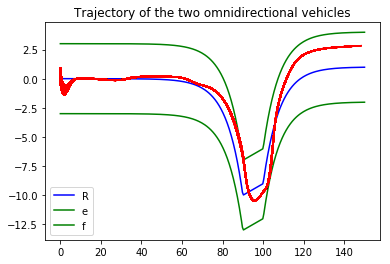

In [575]:
x0s = []
batch_size = 5
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.1 * (2 * random.random() - 1.0)])  # Initial state.

agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_temp_H2.pt')
'''
# Run MPSC guided controller and generate safe trajectory
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)
draw_agent_traj(traj)
draw_str(nn_traj, mpc_traj)

# Collect training trajectory
train_traj_aggr = [i for i in train_traj[:]] * 100
itr = 0

while itr < 1:
    train_traj = train_temp(agent, x0s, train_traj_aggr, paths = None)
    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100
    itr += 1
'''

agent_traj = agent_run(agent, x0s) 
print("Done")
draw_agent_traj(agent_traj)
 

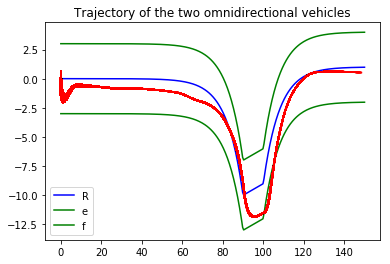

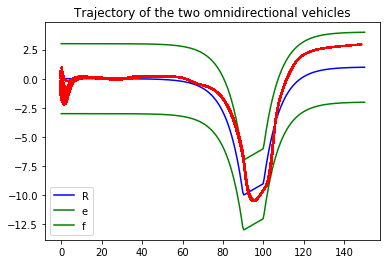

Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

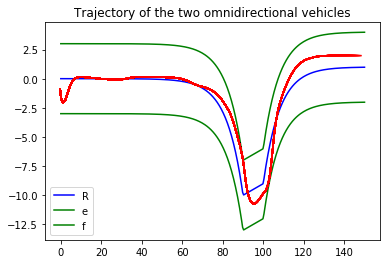

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

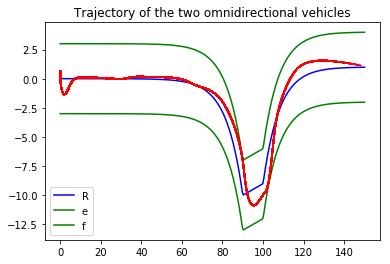

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optim

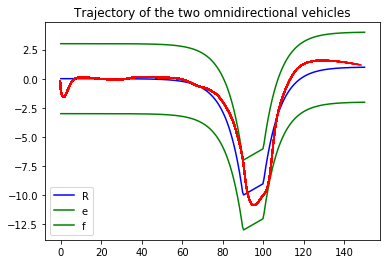

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

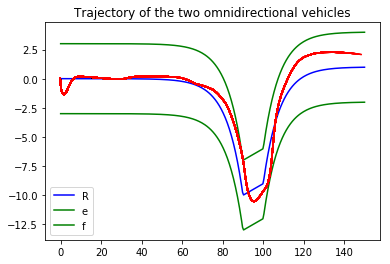

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

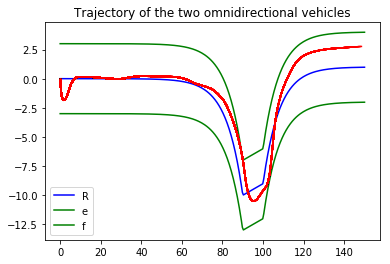

Optimize rajectory 5
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

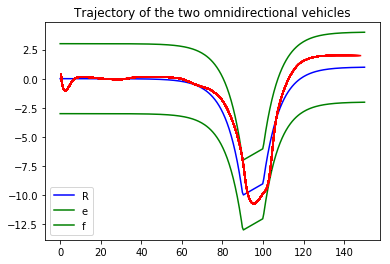

Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

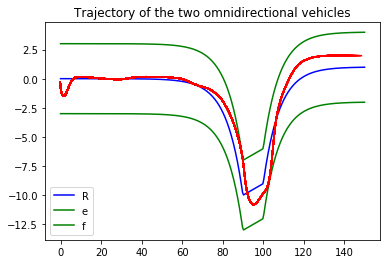

Optimize rajectory 7
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

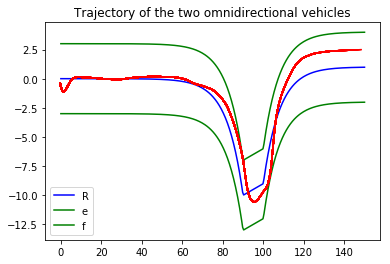

Optimize rajectory 8
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

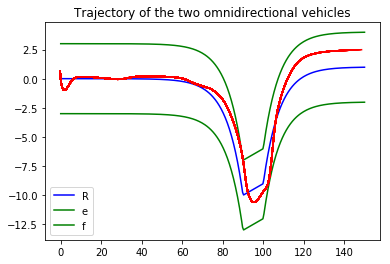

Optimize rajectory 9
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

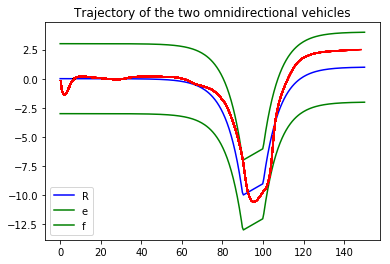

Optimize rajectory 10
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

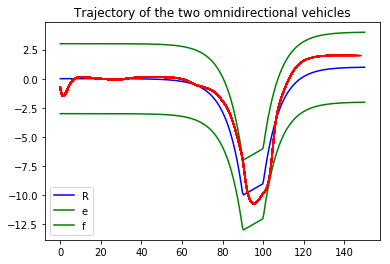

Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

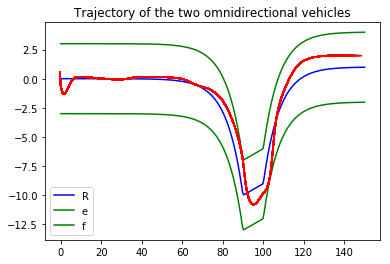

Optimize rajectory 12
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

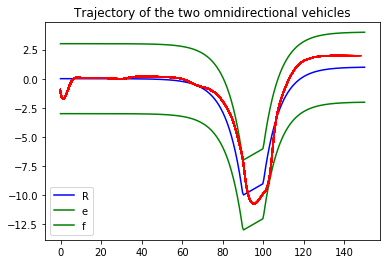

Optimize rajectory 13
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new opti

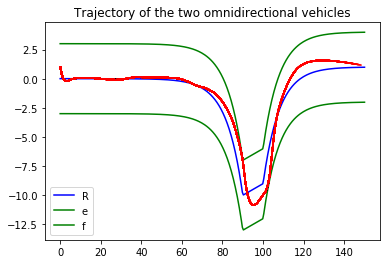

Optimize rajectory 14
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

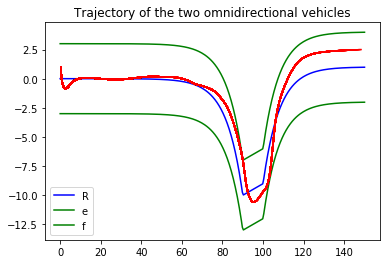

Optimize rajectory 15
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

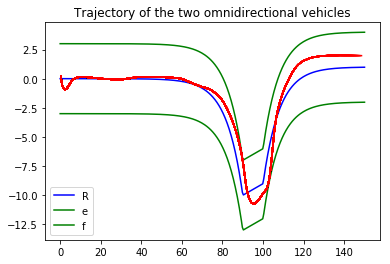

Optimize rajectory 16
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

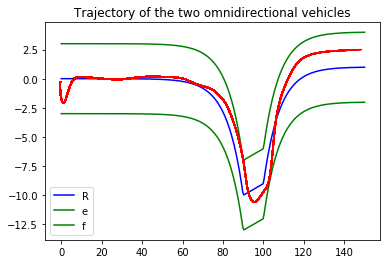

Optimize rajectory 17
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsaf

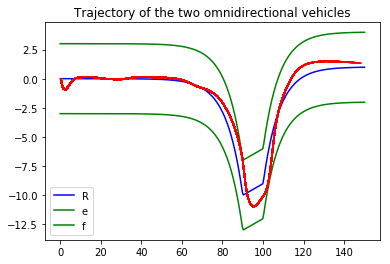

Optimize rajectory 18
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

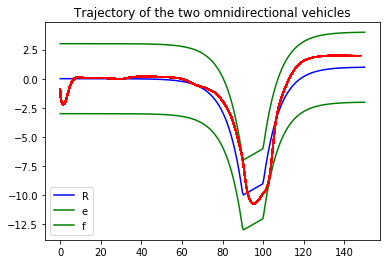

Optimize rajectory 19
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

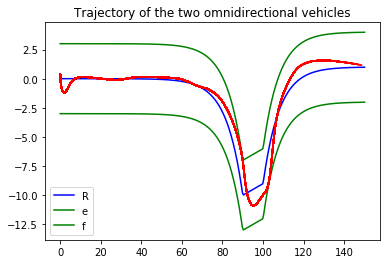

Optimize rajectory 20
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

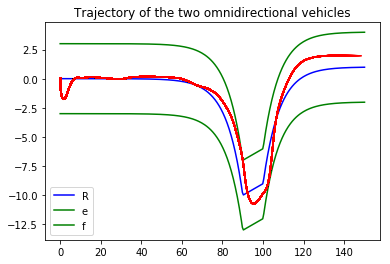

Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  3.7786e-02  1.3160e+00  2e+04  1e+02  5e+07
 1:  2.6728e+00 -6.9777e+02  2e+03  9e+00  4e+06
 2:  6.1536e-01 -5.8922e+01  1e+02  7e-01  3e+05
 3:  7.4122e-02 -4.5182e+00  9e+00  5e-02  2e+04
 4:  9.8569e-03 -3.3142e-01  7e-01  4e-03  2e+03
 5:  1.9955e-03 -3.5009e-02  7e-02  4e-04  2e+02
 6:  3.1243e-04 -4.4000e-03  9e-03  4e-05  2e+01
 7:  9.0947e-05 -7.9051e-04  2e-03  8e-06  4e+00
 8:  2.1463e-05 -9.6276e-05  2e-04  8e-07  4e-01
 9:  5.3493e-06 -1.3217e-05  3e-05  9e-08  4e-02
10:  1.1878e-06 -1.9481e-06  4e-06  9e-09  4e-03
11:  4.8295e-07 -7.8882e-07  2e-06  4e-09  2e-03
12:  1.2683e-07 -1.9189e-07  4e-07  7e-10  3e-04
13:  2.2539e-08 -2.3152e-08  5e-08  7e-12  3e-06
Optimal solution found.


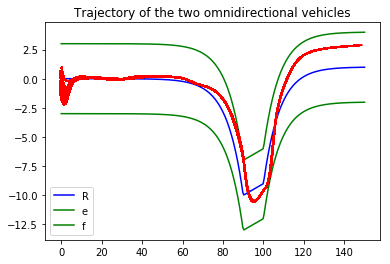

>>>>>>>>>>>>>>>>>>>>
Finished epoch 0
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solut

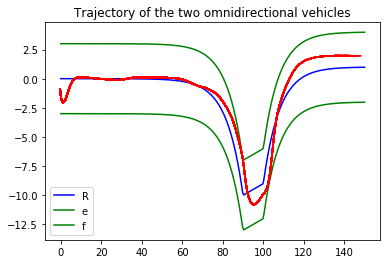

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

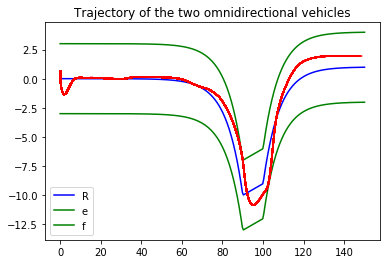

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

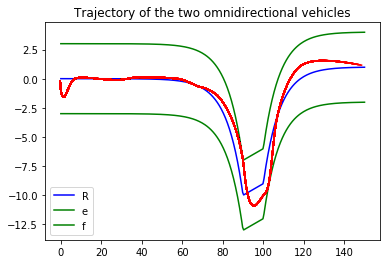

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

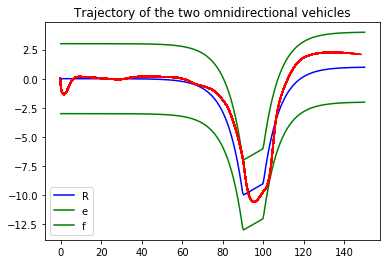

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

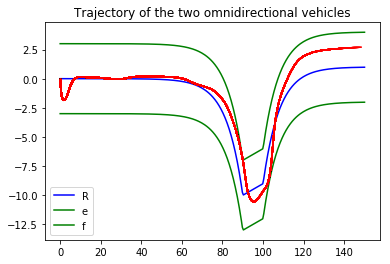

Optimize rajectory 5
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

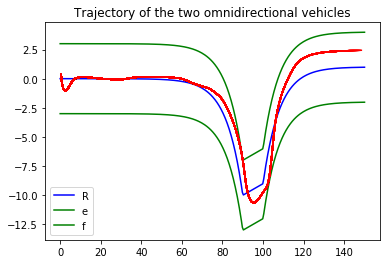

Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

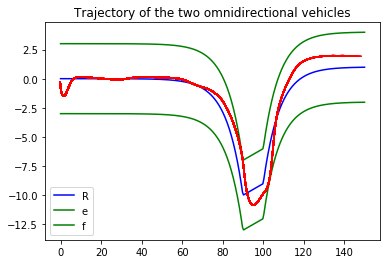

Optimize rajectory 7
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

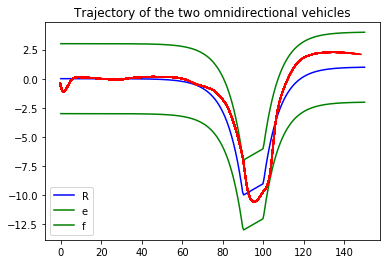

Optimize rajectory 8
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

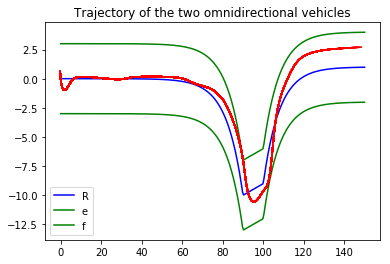

Optimize rajectory 9
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

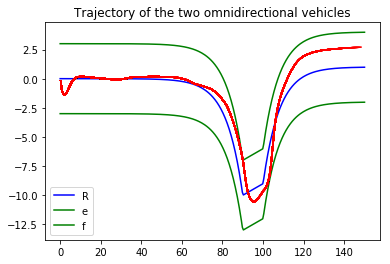

Optimize rajectory 10
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

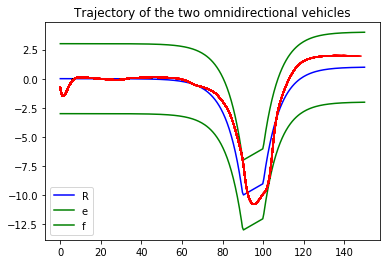

Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

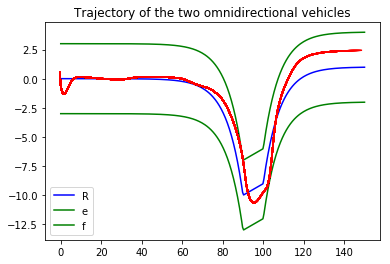

Optimize rajectory 12
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

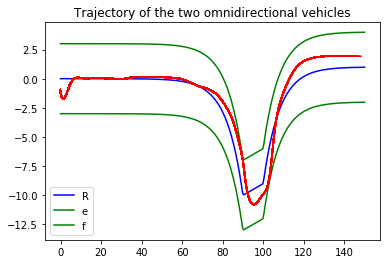

Optimize rajectory 13
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

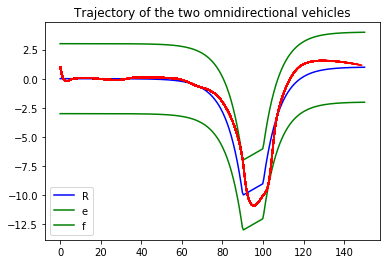

Optimize rajectory 14
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

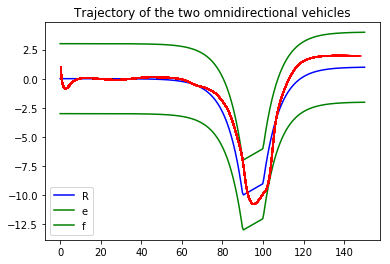

Optimize rajectory 15
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

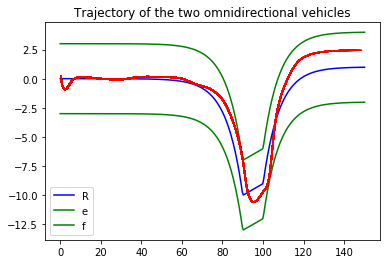

Optimize rajectory 16
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

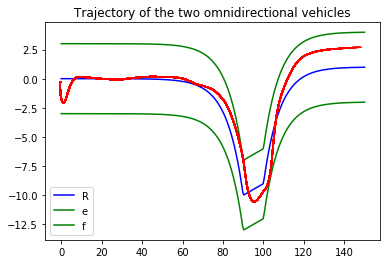

Optimize rajectory 17
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

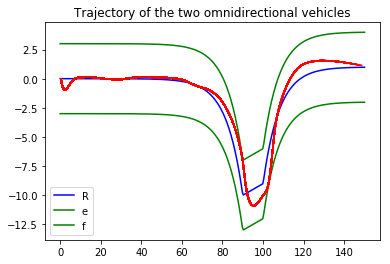

Optimize rajectory 18
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

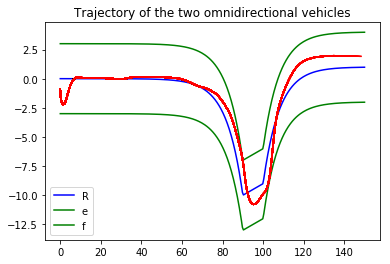

Optimize rajectory 19
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

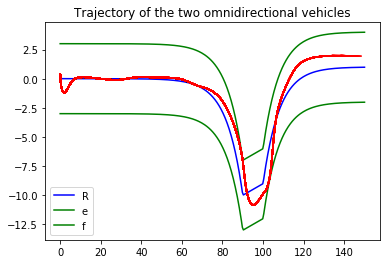

Optimize rajectory 20
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

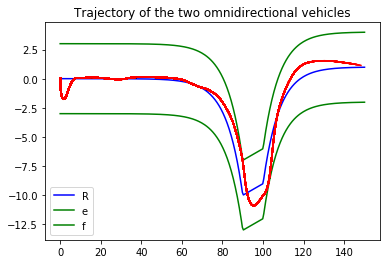

Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  3.0812e-02  1.1137e+00  2e+04  1e+02  5e+07
 1:  2.6812e+00 -6.8099e+02  1e+03  1e+01  4e+06
 2:  5.7902e-01 -5.3560e+01  1e+02  7e-01  3e+05
 3:  7.0695e-02 -4.0203e+00  8e+00  5e-02  2e+04
 4:  9.4240e-03 -2.8623e-01  6e-01  4e-03  1e+03
 5:  1.9475e-03 -3.1671e-02  6e-02  4e-04  2e+02
 6:  2.8483e-04 -3.5151e-03  7e-03  4e-05  2e+01
 7:  8.5570e-05 -6.9276e-04  1e-03  7e-06  3e+00
 8:  2.0513e-05 -8.6712e-05  2e-04  8e-07  3e-01
 9:  5.1032e-06 -1.2180e-05  2e-05  9e-08  4e-02
10:  1.1368e-06 -1.8416e-06  4e-06  9e-09  4e-03
11:  4.6088e-07 -7.4776e-07  2e-06  4e-09  2e-03
12:  1.1024e-07 -1.5823e-07  3e-07  6e-10  2e-04
13:  1.9270e-08 -1.9701e-08  4e-08  6e-12  2e-06
Optimal solution found.


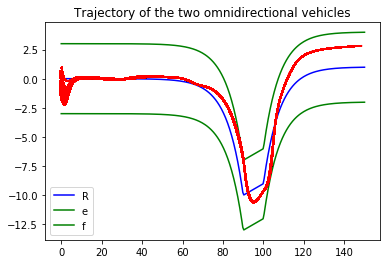

>>>>>>>>>>>>>>>>>>>>
Finished epoch 1
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solut

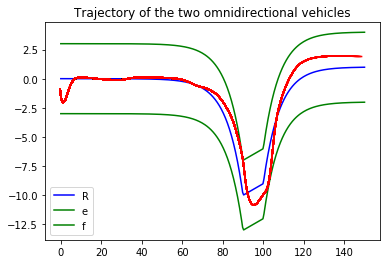

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

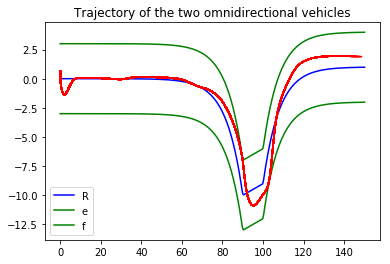

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

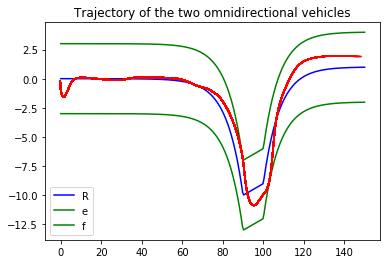

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

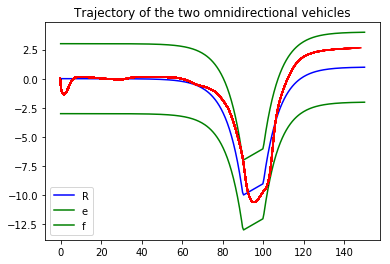

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

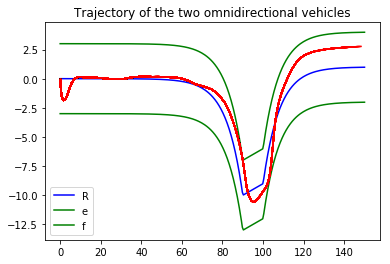

Optimize rajectory 5
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

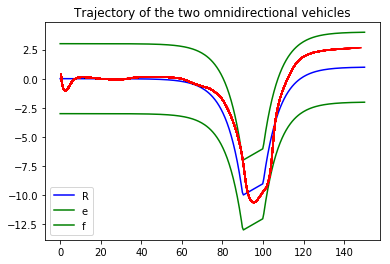

Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

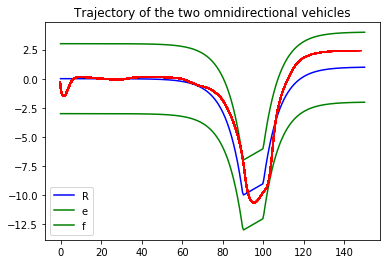

Optimize rajectory 7
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

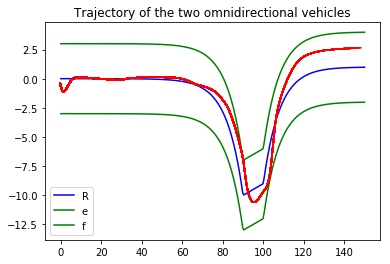

Optimize rajectory 8
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

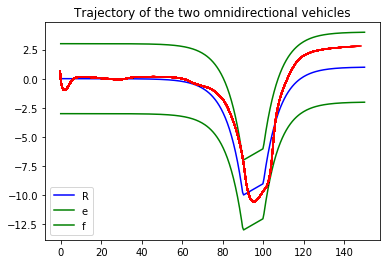

Optimize rajectory 9
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

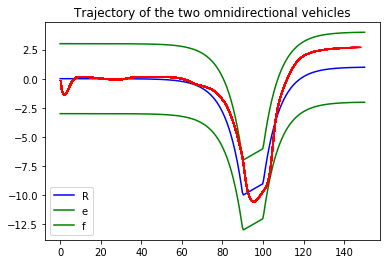

Optimize rajectory 10
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

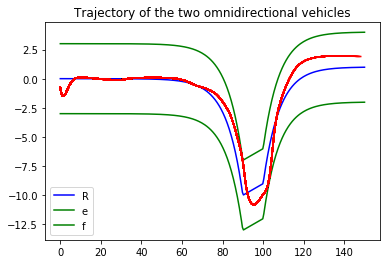

Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

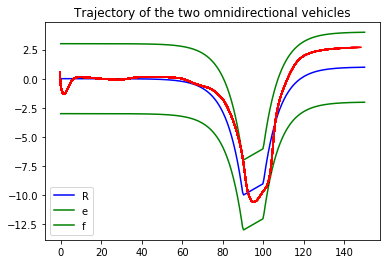

Optimize rajectory 12
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

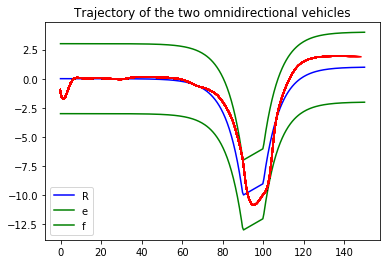

Optimize rajectory 13
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

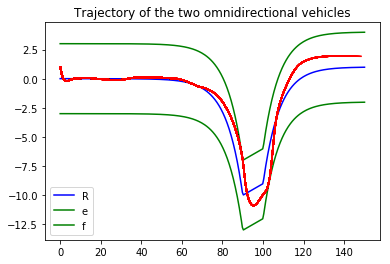

Optimize rajectory 14
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

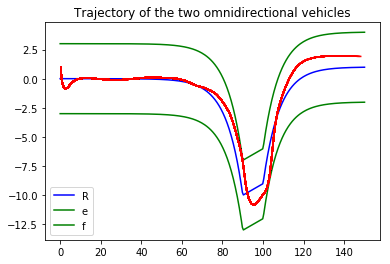

Optimize rajectory 15
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

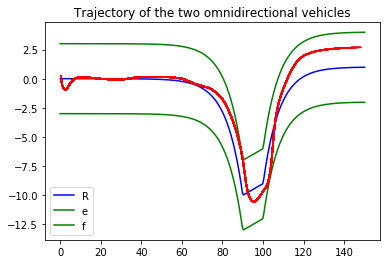

Optimize rajectory 16
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

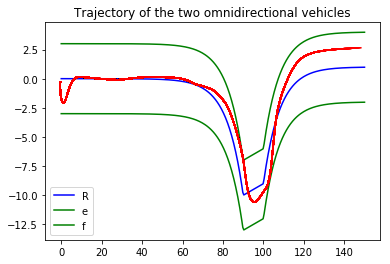

Optimize rajectory 17
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

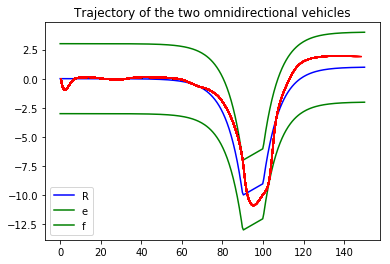

Optimize rajectory 18
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

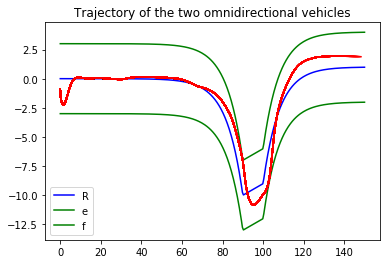

Optimize rajectory 19
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

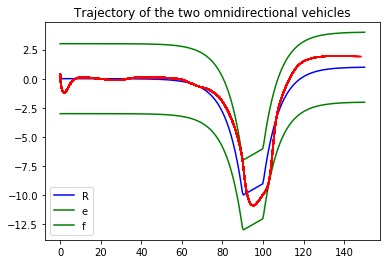

Optimize rajectory 20
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsaf

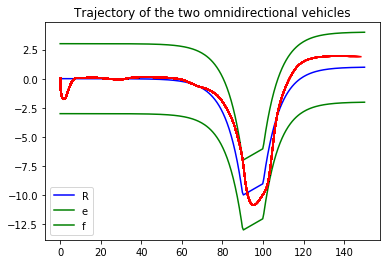

Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  1.3518e-02  5.6349e-01  2e+04  1e+02  5e+07
 1:  2.3248e+00 -5.9231e+02  1e+03  1e+01  4e+06
 2:  5.0150e-01 -4.5413e+01  9e+01  8e-01  3e+05
 3:  6.9450e-02 -4.1685e+00  8e+00  7e-02  2e+04
 4:  9.3327e-03 -2.7241e-01  5e-01  4e-03  2e+03
 5:  1.8348e-03 -3.0689e-02  6e-02  5e-04  2e+02
 6:  2.7636e-04 -3.6551e-03  7e-03  5e-05  2e+01
 7:  8.3220e-05 -7.1235e-04  1e-03  1e-05  3e+00
 8:  1.9550e-05 -8.4259e-05  2e-04  1e-06  3e-01
 9:  4.8686e-06 -1.1883e-05  2e-05  1e-07  4e-02
10:  1.0639e-06 -1.7114e-06  4e-06  1e-08  4e-03
11:  3.8776e-07 -6.1061e-07  1e-06  4e-09  1e-03
12:  9.1477e-08 -1.2756e-07  3e-07  5e-10  2e-04
13:  1.5798e-08 -1.6110e-08  3e-08  5e-12  2e-06
Optimal solution found.


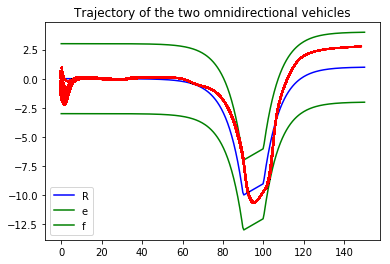

>>>>>>>>>>>>>>>>>>>>
Finished epoch 2
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30

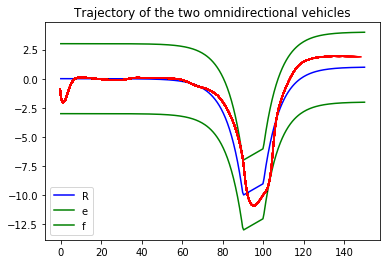

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

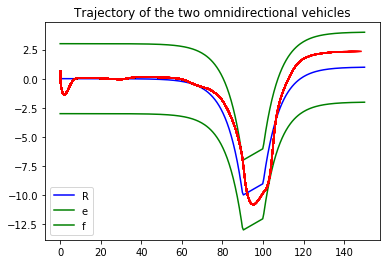

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

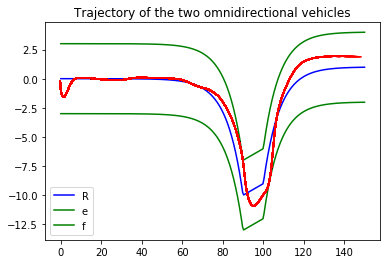

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

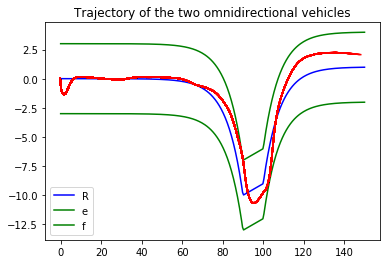

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

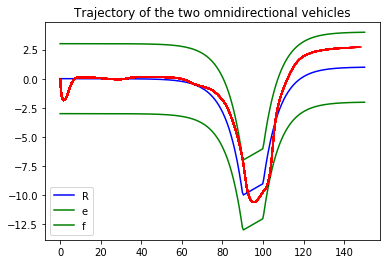

Optimize rajectory 5
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

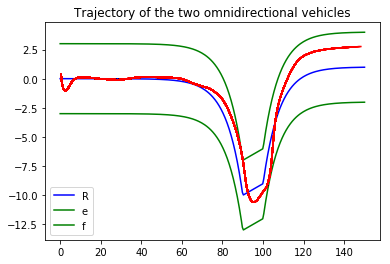

Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

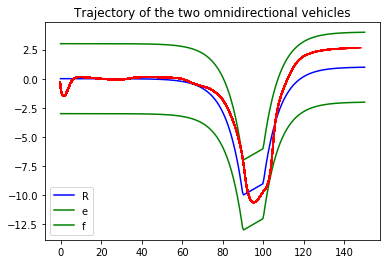

Optimize rajectory 7
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

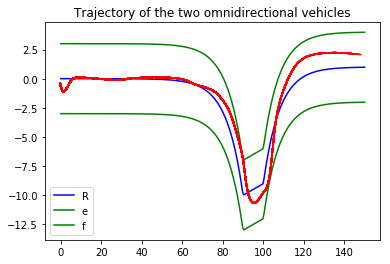

Optimize rajectory 8
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

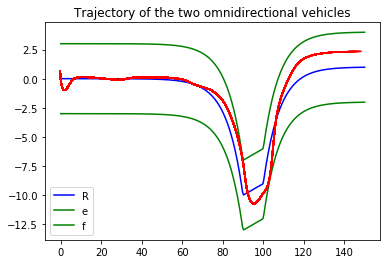

Optimize rajectory 9
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

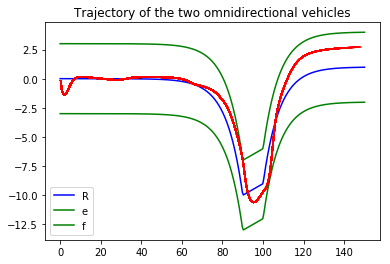

Optimize rajectory 10
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new opti

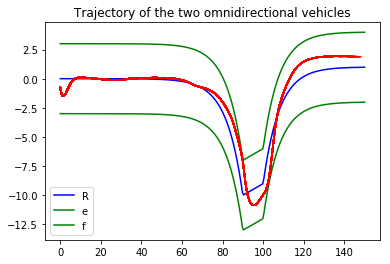

Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

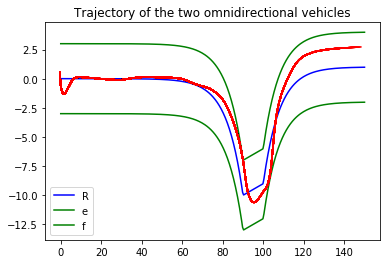

Optimize rajectory 12
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new opti

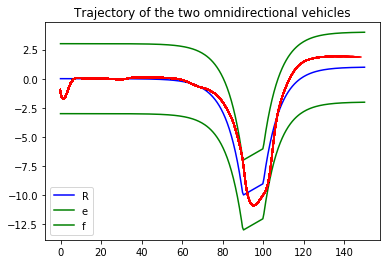

Optimize rajectory 13
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

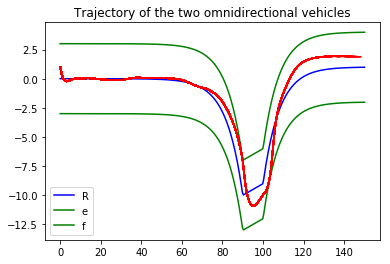

Optimize rajectory 14
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsaf

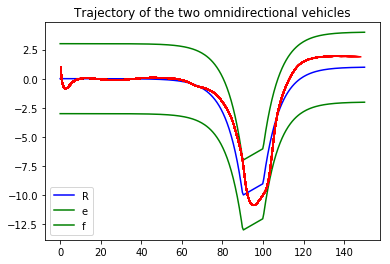

Optimize rajectory 15
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

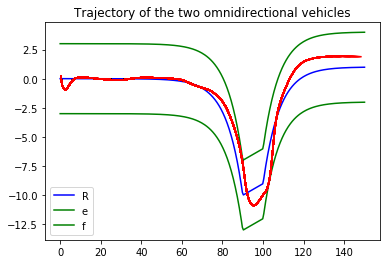

Optimize rajectory 16
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

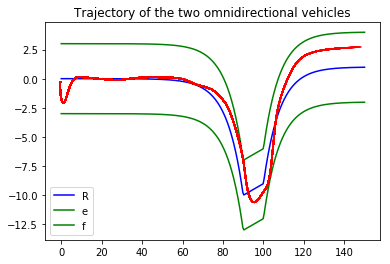

Optimize rajectory 17
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

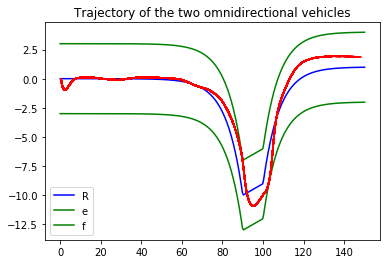

Optimize rajectory 18
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

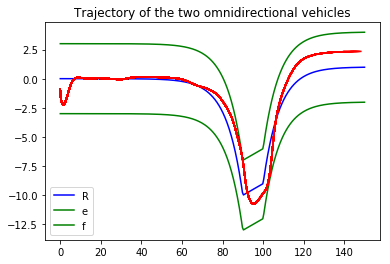

Optimize rajectory 19
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

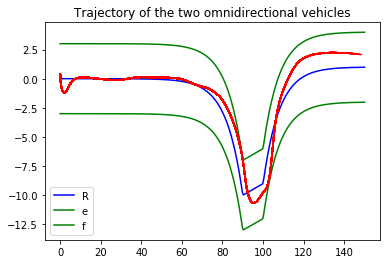

Optimize rajectory 20
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

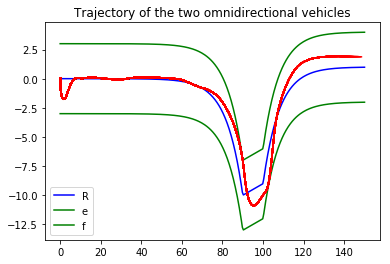

Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  1.5388e-02  5.4274e-01  2e+04  1e+02  5e+07
 1:  2.2179e+00 -6.0957e+02  1e+03  1e+01  4e+06
 2:  4.4351e-01 -4.2067e+01  8e+01  7e-01  2e+05
 3:  6.8255e-02 -4.5427e+00  9e+00  7e-02  3e+04
 4:  9.8749e-03 -3.1455e-01  6e-01  5e-03  2e+03
 5:  1.9069e-03 -3.2462e-02  6e-02  5e-04  2e+02
 6:  2.8083e-04 -3.6542e-03  7e-03  5e-05  2e+01
 7:  8.1794e-05 -6.8888e-04  1e-03  9e-06  3e+00
 8:  1.9165e-05 -8.2794e-05  2e-04  9e-07  3e-01
 9:  4.7893e-06 -1.1719e-05  2e-05  1e-07  4e-02
10:  1.0550e-06 -1.7141e-06  4e-06  1e-08  4e-03
11:  3.9086e-07 -6.2341e-07  1e-06  4e-09  1e-03
12:  9.2483e-08 -1.3036e-07  3e-07  6e-10  2e-04
13:  1.6047e-08 -1.6368e-08  3e-08  6e-12  2e-06
Optimal solution found.


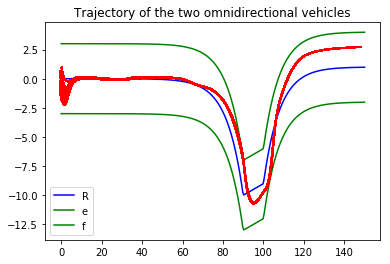

>>>>>>>>>>>>>>>>>>>>
Finished epoch 3
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30

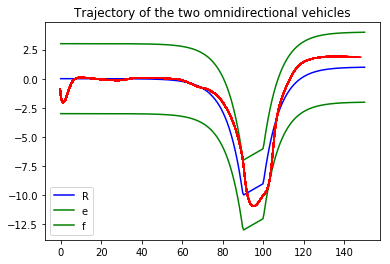

Optimize rajectory 1
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

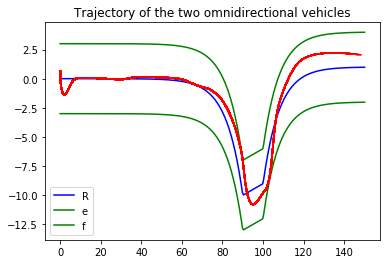

Optimize rajectory 2
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

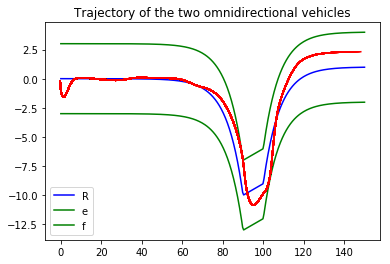

Optimize rajectory 3
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

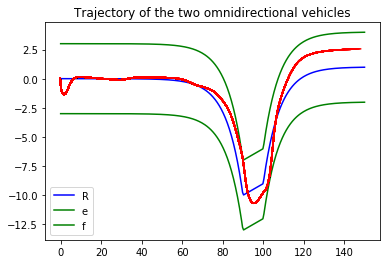

Optimize rajectory 4
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

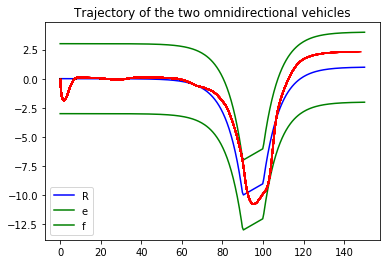

Optimize rajectory 5
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

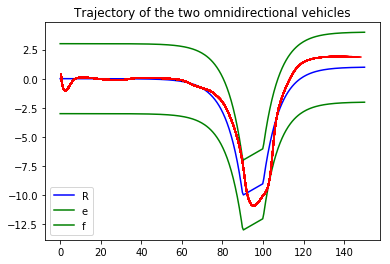

Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

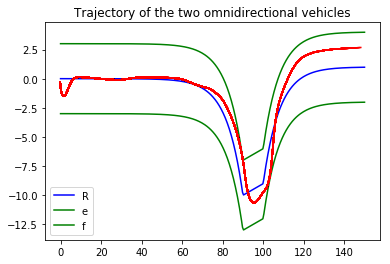

Optimize rajectory 7
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished iter

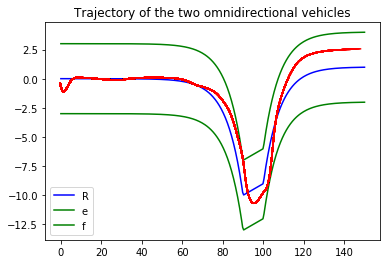

Optimize rajectory 8
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

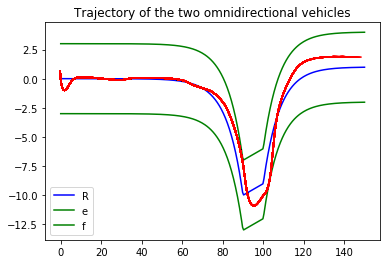

Optimize rajectory 9
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsaf

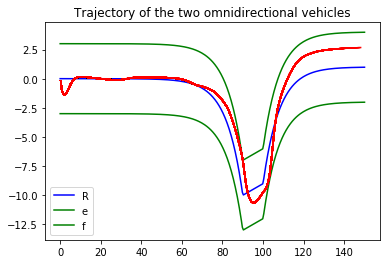

Optimize rajectory 10
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

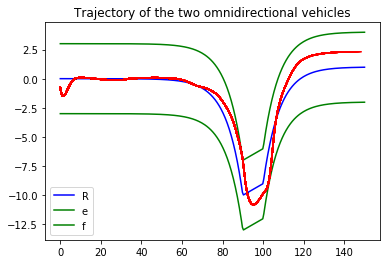

Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

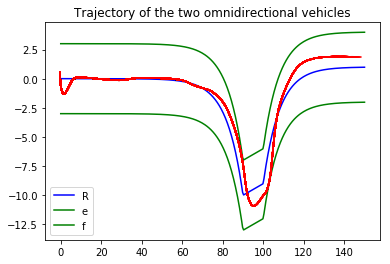

Optimize rajectory 12
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

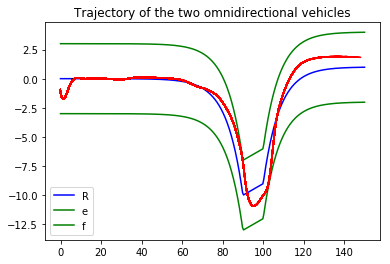

Optimize rajectory 13
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

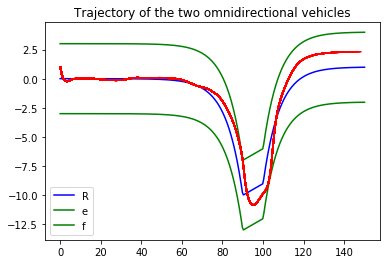

Optimize rajectory 14
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

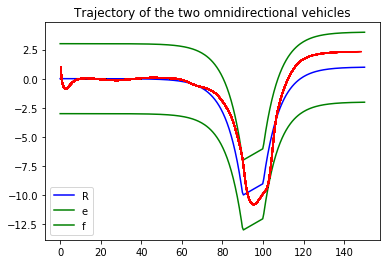

Optimize rajectory 15
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

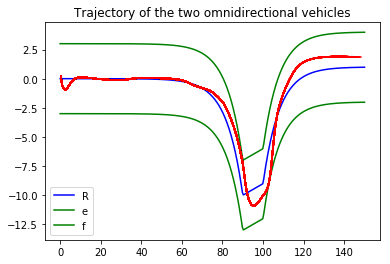

Optimize rajectory 16
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

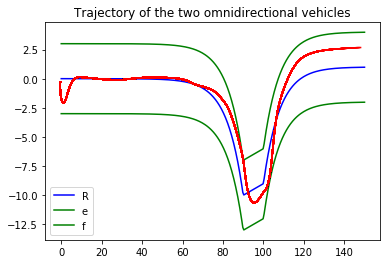

Optimize rajectory 17
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

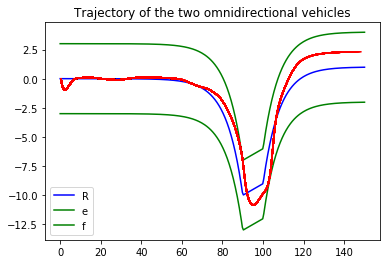

Optimize rajectory 18
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Safe]
Found new optimal solution. Load QP parameters.
Finished ite

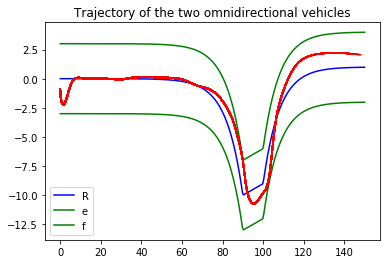

Optimize rajectory 19
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

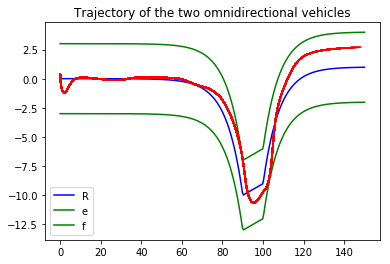

Optimize rajectory 20
Finished iteration 0 [Unsafe]
Finished iteration 1 [Unsafe]
Finished iteration 2 [Unsafe]
Finished iteration 3 [Unsafe]
Finished iteration 4 [Unsafe]
Finished iteration 5 [Unsafe]
Finished iteration 6 [Unsafe]
Finished iteration 7 [Unsafe]
Finished iteration 8 [Unsafe]
Finished iteration 9 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 11 [Unsafe]
Finished iteration 12 [Unsafe]
Finished iteration 13 [Unsafe]
Finished iteration 14 [Unsafe]
Finished iteration 15 [Unsafe]
Finished iteration 16 [Unsafe]
Finished iteration 17 [Unsafe]
Finished iteration 18 [Unsafe]
Finished iteration 19 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 21 [Unsafe]
Finished iteration 22 [Unsafe]
Finished iteration 23 [Unsafe]
Finished iteration 24 [Unsafe]
Finished iteration 25 [Unsafe]
Finished iteration 26 [Unsafe]
Finished iteration 27 [Unsafe]
Finished iteration 28 [Unsafe]
Finished iteration 29 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 31 [Unsa

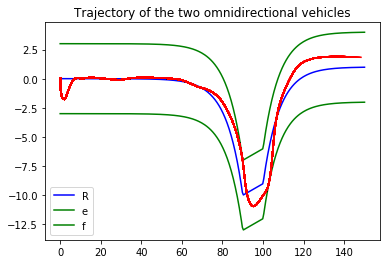

Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  1.0893e-02  4.5718e-01  2e+04  1e+02  5e+07
 1:  2.4221e+00 -5.8250e+02  1e+03  1e+01  4e+06
 2:  5.0331e-01 -4.1399e+01  8e+01  7e-01  2e+05
 3:  6.2910e-02 -4.1879e+00  8e+00  7e-02  2e+04
 4:  9.4465e-03 -2.7373e-01  5e-01  4e-03  2e+03
 5:  1.8284e-03 -2.9849e-02  6e-02  5e-04  2e+02
 6:  2.6831e-04 -3.3328e-03  6e-03  5e-05  2e+01
 7:  7.9778e-05 -6.4694e-04  1e-03  9e-06  3e+00
 8:  1.8818e-05 -7.8864e-05  2e-04  9e-07  3e-01
 9:  4.7118e-06 -1.1422e-05  2e-05  1e-07  4e-02
10:  1.0366e-06 -1.6706e-06  3e-06  1e-08  4e-03
11:  4.1042e-07 -6.5852e-07  1e-06  4e-09  1e-03
12:  9.9636e-08 -1.4306e-07  3e-07  6e-10  2e-04
13:  1.7414e-08 -1.7788e-08  4e-08  6e-12  2e-06
Optimal solution found.


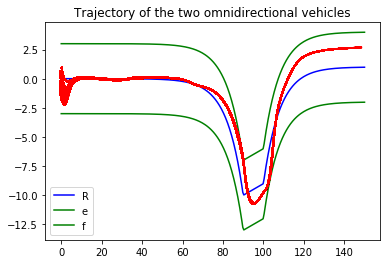

>>>>>>>>>>>>>>>>>>>>
Finished epoch 4


In [583]:
def QP(P_qp, q_qp, G_qp, h_qp, A_qp = None, b_qp = None):
    P_qp = numpy_sparse_to_spmatrix(P_qp)
    q_qp = matrix(q_qp)
    G_qp = numpy_sparse_to_spmatrix(G_qp)
    h_qp = matrix(h_qp)
    print("Starting solving QP")
    solvers.options['feastol'] = 1e-5
    sol=solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
    #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
    theta_diffs = list(sol['x'])
    if theta_diffs is None:
        theta_diffs = np.zeros(agent.num_parameters(agent.model))
    return theta_diffs

#  # loop over the dataset multiple times 
agent_0 = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_traj_0 = agent_run(agent_0, x0s[:5])
draw_agent_traj(agent_traj_0)

agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC_1', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_temp_H2.pt')
agent_traj = agent_run(agent, x0s[:])
draw_agent_traj(agent_traj)

data_trajs = agent_traj

num_epoch = 5
tol = 1e-5

for epoch in range(num_epoch):
    # Initialize Q matrix 
    Q1 = []
    Qx = []
    Qu = []
    Qx_T = []
    Qu_T = []
    Qxx = []
    Quu = []
    Qux = []
    Qxu = []

    # Initialize K, k
    K = []
    k = []

    # Run the latest model and original model to get (pi_\theta - u^*)
    u_diffs = []
    # Run the latest model to get gradient on the input x   
    pix = []
    # Run the latest model to get gradient on \theta
    pitheta = []

    # Barrier 1st order and 2nd order
    b1 = []
    bx = []
    bx_T = []
    bxx = []

    xs_diff = []
    us_diff = []
        
    h_qp = []
    G_qp = []
    
    theta_diffs = np.zeros([len(data_trajs), agent.num_parameters(agent.model)])
    P_qp = np.eye(agent.num_parameters(agent.model))
    q_qp = np.zeros([agent.num_parameters(agent.model), 1])
    
    num_itr = 10
    
    for i_traj in range(len(data_trajs)):
        print("Optimize rajectory {}".format(i_traj))
        Q1.append(np.empty([len(data_trajs[i_traj]), 1, 1]))
        Qx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1])) 
        Qu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        Qx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size])) 
        Qu_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.action_size]))
        Qxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))
        Quu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.action_size]))
        Qux.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        Qxu.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))

        # Initialize K, k
        K.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        k.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        # Run the latest model and original model to get (pi_\theta - u^*)
        u_diffs.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        # Run the latest model to get gradient on the input x   
        pix.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))
        # Run the latest model to get gradient on \theta
        pitheta.append(np.empty([len(data_trajs[i_traj]), \
                                 agent.num_parameters(agent.model), dynamics.action_size]))

        # Barrier 1st order and 2nd order
        b1.append(np.empty([len(data_trajs[i_traj]), 1]))
        bx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        bx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size]))
        bxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))

        xs_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        us_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        h_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size, 1]))
        G_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size , \
                              agent.num_parameters(agent.model)]))
        
        data_traj_opt = data_trajs[i_traj][:]
        J_opt = float('inf')
        converged = False
        
        alphas = 0.9**(np.arange(num_itr)**2)
        mus = 1.1**(np.arange(num_itr)**2)
        
        for i_itr in range(num_itr**2):
            alpha = alphas[int(i_itr/num_itr)]
            mu = mus[int(i_itr%num_itr)] 
            
            data_traj = data_trajs[i_traj][:]
            x_new = np.reshape([i for i in data_traj[0][0][:4]], [dynamics.state_size, 1])
            
            data_traj_tmp = []
            xs = []
            us = []
            
            agent.optimizer.zero_grad()
            J_new = 0.0
            
            for i_xy in range(len(data_traj)):
                x_y = data_traj[i_xy]
                x = np.reshape([i for i in x_y[0][:4]], [dynamics.state_size, 1])
                u = np.reshape([i for i in x_y[1][:]], [dynamics.action_size, 1])

                x_u = x - np.array([[0.0], [barrier_u(x[0, 0])[1]], [0.0], [0.0]])
                x_l = x - np.array([[0.0], [barrier_l(x[0, 0])[1]], [0.0], [0.0]])

                b1[i_traj][i_xy] = q1[0] * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) - q1[0]\
                        + q1[1] * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) - q1[1]
                bx[i_traj][i_xy] = q1[0] * q2[0]\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T + q1[1] * q2[1]\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T
                
                bx_T[i_traj][i_xy] = bx[i_traj][i_xy].T

                bxx[i_traj][i_xy] = q1[0] * q2[0]**2\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T * A[0]\
                    + q1[1] * q2[1]**2\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T * A[1]

                i = abs(int(x[0]/0.5))
                x_nn = []
                for j in [x[:, 0]] + x_nominal[i : i + H]:
                    for e in j:
                        x_nn.append(e)
                while len(x_nn) < 4 *(H + 1):
                    for e in x_nominal[-1]:
                        x_nn.append(e)

                x_nn = np.asarray(x_nn)
                x_input = torch.tensor([x_nn], requires_grad = True).float().to(agent.device)   
                u_output = agent.model(x_input)[0]
                
                for i in range(dynamics.action_size):
                    # Get gradient w.r.t input x[0:4] <<<< pix 
                    pix[i_traj][i_xy, :, i] = torch.autograd.grad(\
                    u_output[i], x_input, retain_graph = True)[0].cpu().numpy().T[0:dynamics.state_size, 0]

                    # Get gradient w.r.t model parameters theta <<<< g_theta
                    torch.autograd.backward(u_output[i], retain_graph = True)
                    j = 0
                    for theta in agent.model.parameters():
                        pitheta_ = theta.grad.data.flatten()
                        pitheta[i_traj][i_xy, j : j + pitheta_.size()[0], i] = pitheta_.cpu().numpy()
                        j += pitheta_.size()[0]    

                u_output = u_output.detach().cpu().numpy()
                u_output = np.reshape(u_output, [dynamics.action_size, 1])

                u_0 = agent_0.run([x_nn])[0]
                u_0 = np.reshape(u_0, [dynamics.action_size, 1])

                u_diffs[i_traj][i_xy] = u_output - u_0

                Q1[i_traj][i_xy] = 4 * b1[i_traj][i_xy]
                Qx[i_traj][i_xy] = -2 * pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy]) + \
                                    2 * bx[i_traj][i_xy]
                Qx_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T) + \
                                    2 * bx[i_traj][i_xy].T
                Qu[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy]
                Qu_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T

                Qxx[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(\
                                    u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T)) + 2 * bxx[i_traj][i_xy]
                Quu[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T) + \
                            mu * np.eye(Quu[i_traj][i_xy].shape[0])
                Qux[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T))
                Qxu[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(u_diffs[i_traj][i_xy].T)

                K[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qux[i_traj][i_xy])
                k[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qu[i_traj][i_xy])

                x_diff = x_new - x

                us_diff[i_traj][i_xy] = alpha * k[i_traj][i_xy] + K[i_traj][i_xy].dot(x_diff)
                xs_diff[i_traj][i_xy] = x_diff
                
                u_new = u_output + us_diff[i_traj][i_xy]
                u_new = u_new.flatten().tolist()
                x_new = x_new.flatten().tolist()
                
                data_traj_tmp.append([x_new, u_new])
                xs.append(x_new)
                us.append(u_new)

                if i_xy < len(data_traj) - 1:
                    x_new = dynamics.f(xs[-1], us[-1], i_xy)[0]
                    x_new = np.reshape(x_new, x.shape)

            
            if (np.squeeze((np.asarray(xs) - \
                np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - \
                           b[0,0] <= 0)).all() == True and \
               (np.squeeze((np.asarray(xs) - \
                np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - \
                           b[1,0] <= 0)).all() == True:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Safe]".format(i_itr))
                #draw_agent_traj([data_traj_tmp])
                
                for i_xy in range(u_diffs[i_traj].shape[0]):                    
                    J_new += np.sum(Q1[i_traj][i_xy] + \
                                    2 * xs_diff[i_traj][i_xy].T.dot(Qx[i_traj][i_xy]) + \
                                    2 * us_diff[i_traj][i_xy].T.dot(Qu[i_traj][i_xy]) + \
                                    2 * (xs_diff[i_traj][i_xy].T.dot(Qxu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]) + \
                                    (xs_diff[i_traj][i_xy].T.dot(Qxx[i_traj][i_xy])).dot(xs_diff[i_traj][i_xy]) + \
                                    (us_diff[i_traj][i_xy].T.dot(Quu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]))
                if J_opt > J_new:
                    if np.abs((J_opt - J_new)/J_opt) < tol:
                        converged = True
                        print("Converged.")
                        break
                    print("Found new optimal solution. Load QP parameters.")
                    for i_xy in range(len(data_traj)):
                        h_i = (us_diff[i_traj][i_xy].T - xs_diff[i_traj][i_xy].T.dot(pix[i_traj][i_xy])).T
                        G_i = pitheta[i_traj][i_xy].T

                        for j in range(dynamics.action_size):
                            h_qp[i_traj][i_xy + j, :] = h_i[j, 0]
                            G_qp[i_traj][i_xy + j, :] = G_i[j, :]
                    J_opt = J_new
                    data_traj_opt = data_traj_tmp[:]
                    
                #alpha = 1.1 * (1.0 + 0.9**i_itr) * alpha 
                #mu = 0.9 * (1.0 - 0.9**i_itr) * mu
                
            else:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Unsafe]".format(i_itr))  
                #draw_agent_traj([data_traj_tmp])
                #alpha = 0.9 * (1 - 0.9**i_itr) * alpha
                #mu = 1.1 * (1 + 0.9**i_itr) * mu 
        
        data_trajs[i_traj] = data_traj_opt[:]
        draw_agent_traj([data_traj_opt])
    
    
    pickle.dump((G_qp, h_qp), open('linear_eq.p', 'wb'))
    
    #for i_traj in range(len(theta_diffs)):  
    #    theta_diffs[i_traj] = np.asarray(QP(P_qp, q_qp, G_qp[i_traj], h_qp[i_traj]))
    #theta_diffs = np.mean(theta_diffs, axis = 0)
    
    h_qp = np.concatenate(h_qp[:])
    G_qp = np.concatenate(G_qp[:])
    theta_diffs = np.asarray(QP(P_qp, q_qp, G_qp, h_qp))
    
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = linalg.cgs(G_qp.T.dot(G_qp), G_qp.T.dot(h_qp))[0]
    
    i = 0
    for theta in agent.model.parameters():
        theta.data += torch.FloatTensor(\
            np.reshape(theta_diffs[i: i + theta.data.numel()], theta.data.size())).to(agent.device)
        i += theta.data.numel()
        
    data_trajs = agent_run(agent, x0s)
    draw_agent_traj(data_trajs)
    print(">>>>>>>>>>>>>>>>>>>>")
    print("Finished epoch {}".format(epoch))
        